In [1]:
# Load up packages
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import xarray as xr
import pandas as pd
from sklearn.tree import  DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
import sys
import pickle
import os
import warnings
from tqdm import tqdm
import cartopy.crs as ccrs
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams.update({'font.size': 14})

sys.path.append('../..')
from src.models.ml_functions import  RF_regressor, plot_importances, XGBoost_regressor, Tu_label, encode_tulabel, XGBoost_regressor_tuned
from src.visualisation.visual_func import create_testdf, plot_std_lat, plot_residuals, stereo_plot
from src.models.corr_func import calc_correlation, plot_correlations, correlation_matrix
from src.models.learning_curve import learning_curve
from src.utils.directories import get_parent_directory
from src.models.corr_func import score_metrics, confidence_metrics

In [2]:
parent_dir = get_parent_directory()
parent_dir

'/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence'

## Massive regularisation and bin

In [7]:
arctic_pkl = (os.path.join(parent_dir, "data/processed/ml_ready/2706_time.pkl"))
arctic_df = pd.read_pickle(arctic_pkl)
MLD_df = arctic_df[arctic_df['depth'] >= arctic_df['MLDJ']]

# Convert 'inf' and '-inf' to 'NaN'
MLD_df = MLD_df.replace([np.inf, -np.inf], np.nan)

# Drop rows with 'NaN' values
MLD_df = MLD_df.dropna()

# Bin MLD_df to 10m

In [32]:
import numpy as np

# Round depth down to the nearest integer
MLD_df['rounded_depth'] = np.floor(MLD_df['depth']).astype(int)

# Filter the DataFrame to include only values that are multiples of ten
filtered_df = MLD_df[MLD_df['rounded_depth'] % 10 == 0]


# Group the DataFrame by cruise
grouped_df = filtered_df.groupby('cruise')

# Create an empty DataFrame to store the filtered data
filtered_df_1500 = pd.DataFrame()

# Iterate over each group (cruise) in the grouped DataFrame
for cruise, group in grouped_df:
    # Check if the group has more than 1500 points
    if len(group) > 1500:
        # Randomly select 1500 points from the group
        selected_points = group.sample(n=1500, random_state=42)  # Adjust the random_state if desired
        
        # Append the selected points to the filtered DataFrame
        filtered_df_1500 = filtered_df_1500.append(selected_points)
    else:
        # If the group has less than or equal to 1500 points, append all points
        filtered_df_1500 = filtered_df_1500.append(group)

In [24]:
# Create the XGBoost regressor
import xgboost as xgb
xgb_regressor = xgb.XGBRegressor(
    max_depth=7,
    n_estimators=300,
    learning_rate=0.01,
    reg_alpha=0.1,    # Regularization parameter (L1)
    reg_lambda=0.1,   # Regularization parameter (L2)
    random_state=42
    )

In [36]:
MLD_df.cruise.unique()

array(['NICE-2015', 'ArcticMix', 'Mosaic', 'Haakon Mosby', 'ABSO',
       'TEA_COSI', 'IPY Barneo 2007', 'IPY Barneo 2008',
       'Nansen Legacy 2018', 'Nansen Legacy 2019', 'ASCOS'], dtype=object)

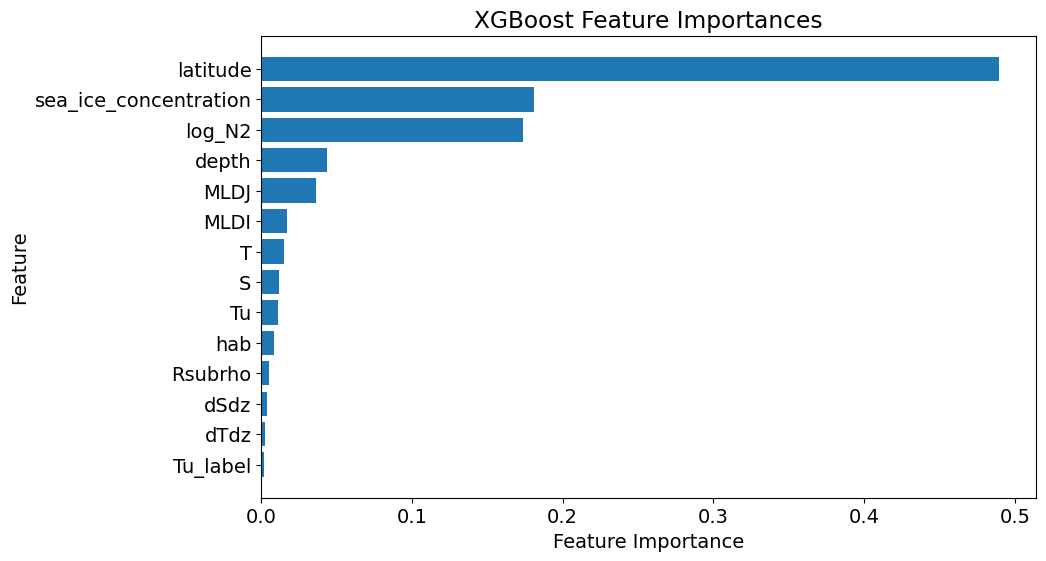

In [48]:
# excluded 'sea_ice_concentration','latitude', 
xstring= ['depth', 'hab','S','T','dSdz','dTdz','log_N2', 'Tu_label', 'MLDJ', 'MLDI', 'Rsubrho', 'sea_ice_concentration', 'latitude', 'Tu']

ystring = ['log_eps']
(xgb_regressor, r2, y_test, y_pred, X_test, feature_importances, X_train, y_train) = XGBoost_regressor(filtered_df_1500, xstring, ystring, manual_regressor=xgb_regressor, cruise_test="IPY Barneo 2007", cv=None)

In [69]:
r2

-2.566144003761596

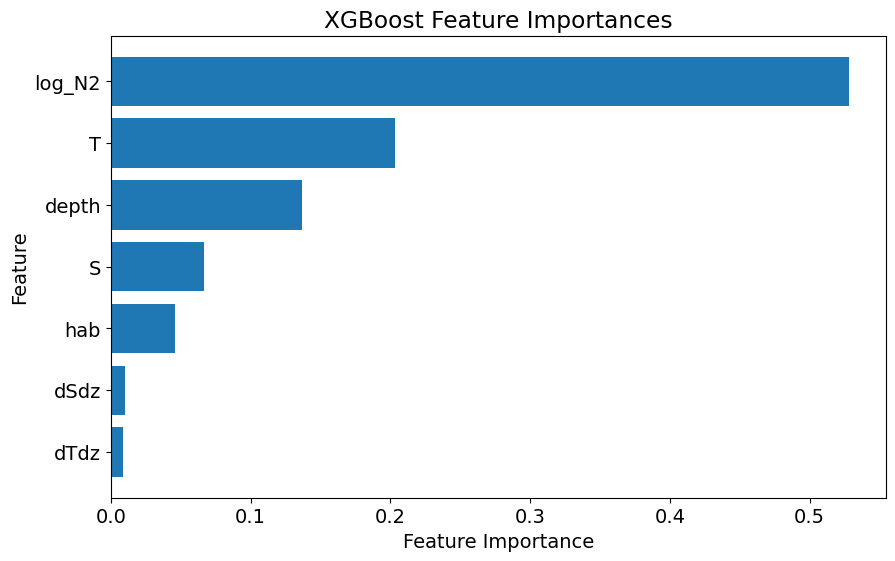

In [88]:
# excluded 'sea_ice_concentration','latitude', 
# xstring= ['depth', 'hab','S','T','dSdz','dTdz','log_N2', 'Tu_label', 'MLDJ', 'MLDI', 'Rsubrho', 'sea_ice_concentration', 'latitude', 'Tu']
xstring= ['depth', 'hab','S','T','dSdz','dTdz','log_N2']
          
ystring = ['log_eps']
(xgb_regressor, r2, y_test, y_pred, X_test, feature_importances, X_train, y_train) = XGBoost_regressor(filtered_df_1500, xstring, ystring, manual_regressor=xgb_regressor, cruise_test="NICE-2015", cv=None)

R2 Score: -23.3981, 95% CI: [-30.1970, -18.3022]
Mean Error (ME): -1.0236, 95% CI: [-1.1102, -0.9413]
Mean Absolute Error (MAE): 1.1803, 95% CI: [1.1068, 1.2605]
Residual Standard Deviation: 1.6399, 95% CI: [1.4845, 1.7919]


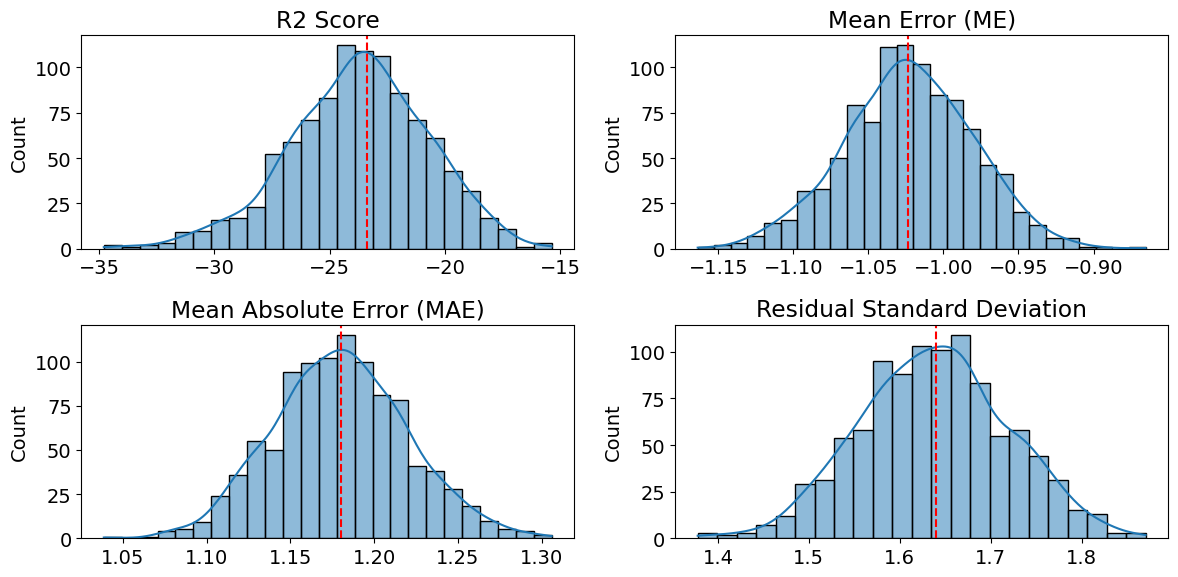

In [89]:
confidence_metrics(y_test, y_pred)

In [120]:
def stereo_plot(merged_df, variable, name_var):
    """
    Creates a polar stereographic plot of longitude and latitude with colored
    residuals.

    Parameters:
        merged_df (pd.DataFrame): A dataframe containing longitude and
            latitude information.
        variable (np.ndarray): An array of values representing the variable
            of interest.
        name_var (str): The name of the variable for the colorbar label.

    Returns:
        None

    Example:
        # Assuming merged_df is a dataframe with columns 'longitude' and
        # 'latitude' variable is an array of values, and name_var is a string
        stereo_plot(merged_df, variable, name_var)
    """

    # Create a polar stereographic projection centered on the Arctic pole
    projection = ccrs.NorthPolarStereo(central_longitude=0)

    # Create a figure and axes using the polar stereographic projection
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': projection})

    # Plot longitude and latitude with colored residuals
    sc = ax.scatter(merged_df['longitude'], merged_df['latitude'],
                    c=(variable), # vmin=0, vmax=1,
                    cmap='viridis', transform=ccrs.PlateCarree())

    # Add colorbar
    cbar = plt.colorbar(sc, ax=ax, label=name_var)

    # Set map extent to focus on the Arctic region
    ax.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())

    # Add map features
    ax.coastlines()
    ax.gridlines()

    # Set plot title and labels
    plt.title(f"{name_var} based on cruise location")
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    # Show the plot
    plt.show()



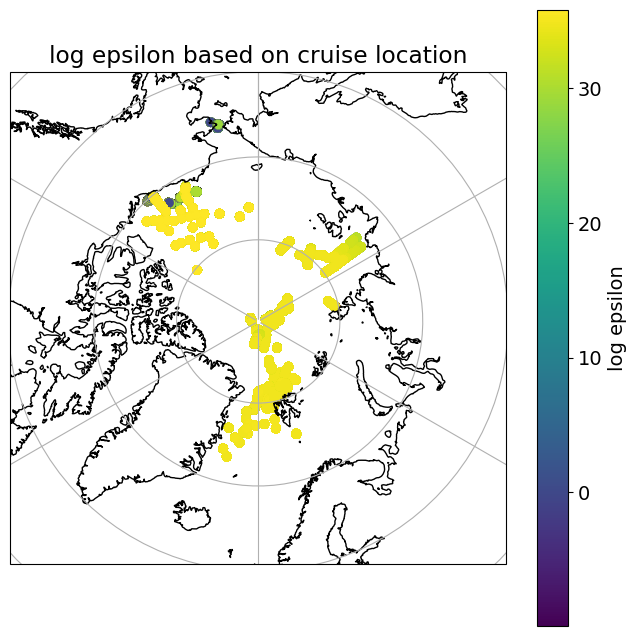

In [122]:
stereo_plot(arctic_df, arctic_df["S"], "log epsilon")

In [80]:
r2

0.9458797397971636

In [53]:
from src.models.encode_features import encode_tulabeldict

In [59]:
MLD_df, label = encode_tulabeldict(MLD_df)

In [61]:
y_pred_df_SIC = pd.DataFrame(y_pred, columns=ystring)
# Rename the 'eps_pred' column to 'log_eps'
y_pred_df_SIC = y_pred_df_SIC.rename(columns={'log_eps': 'eps_pred'})

# Reset index on y_pred_df_SIC and y_test_df_SIC
y_pred_df_SIC.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

# Create a new dataframe with index column
index_df_SIC = pd.DataFrame({'index': range(len(y_pred_df_SIC))})

# Merge y_pred_df_SIC and y_test_df_SIC on index_df_SIC
SIC_all_testdf = pd.concat([index_df_SIC, y_test, y_pred_df_SIC], axis=1)
SIC_all_testdf =  pd.concat([SIC_all_testdf, X_test], axis=1)

# Drop the 'index' column
SIC_all_testdf = SIC_all_testdf.drop('index', axis=1)

merged_df_SIC = SIC_all_testdf.merge(MLD_df, on=xstring+ystring)

In [62]:
merged_df_SIC = merged_df_SIC.drop_duplicates(subset=xstring+ystring)
residuals_SIC = (merged_df_SIC["log_eps"] - merged_df_SIC["eps_pred"])
merged_df_SIC["residuals"] = residuals_SIC 
merged_df_SIC["abs_residuals"] = residuals_SIC.abs()

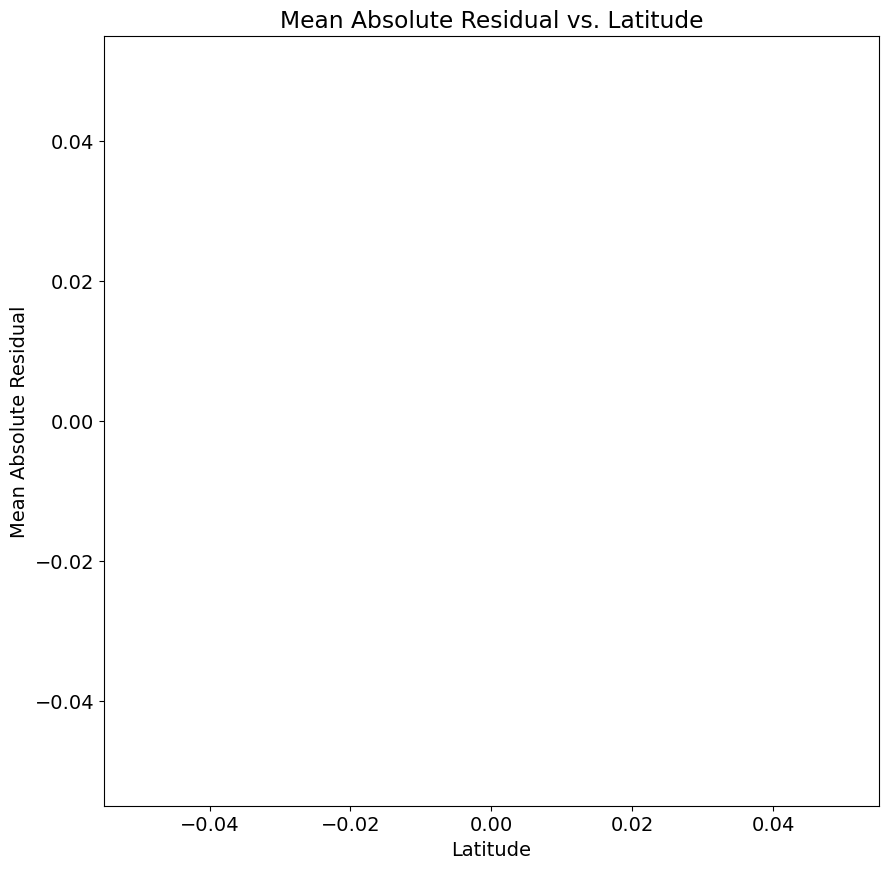

In [63]:
# Calculate mean absolute residual per latitude
mean_residuals = merged_df_SIC.groupby('latitude')['residuals'].mean().abs()

# Plot mean absolute residual per latitude using a scatter plot
plt.scatter(mean_residuals.index, mean_residuals.values)
plt.xlabel('Latitude')
plt.ylabel('Mean Absolute Residual')
plt.title('Mean Absolute Residual vs. Latitude')
plt.show()

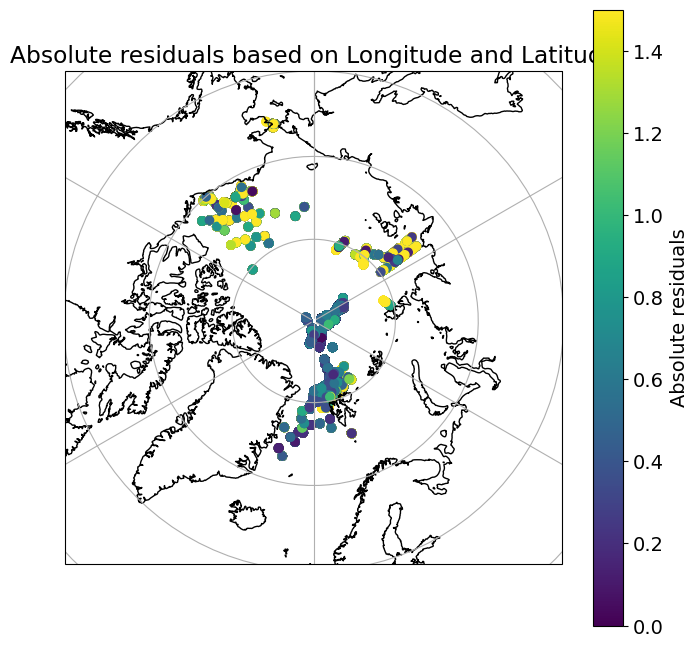

In [84]:
stereo_plot(merged_df_SIC, merged_df_SIC["abs_residuals"], "Absolute residuals", vmin = 0, vmax = 1.5)

In [97]:
def plot_residuals(test_df):
    """
    Plots the absolute residuals between the true and predicted epsilon value
    as a scatter plot.

    Parameters:
        test_df (pd.DataFrame): A dataframe containing the test data features,
        true epsilon values, and predicted epsilon values.

    Returns:
        None

    Example:
        # Assuming test_df is a dataframe with columns 'latitude', 'depth',
        # 'log_eps' (true epsilon values), and 'eps_pred'
        plot_residuals(test_df)
    """
    abs_residual = np.abs(test_df['log_eps'] - test_df['eps_pred'])

    # Define the x and y coordinates for the scatter plot
    latitude = test_df['latitude'].values
    depth = test_df['depth'].values
    depth = np.where(depth > 500, 500, depth)

    # Create a scatter plot of the absolute residuals
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(latitude, depth, c=abs_residual, cmap='plasma', s=50)

    plt.xlabel('Latitude')
    plt.ylabel('Depth')
    plt.title('Absolute Residual between Epsilon and Epsilon_pred')

    # Invert the y-axis
    plt.gca().invert_yaxis()

    # Show the plot
    plt.show()



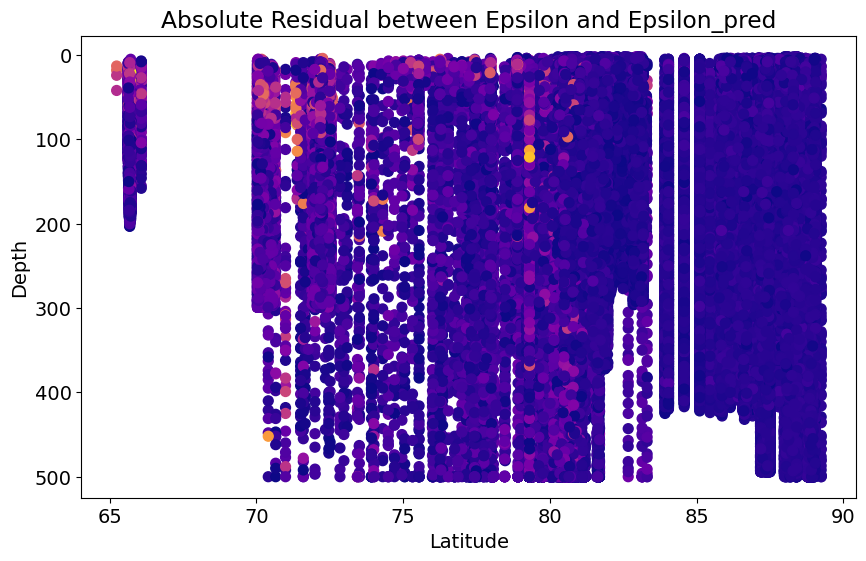

In [98]:
plot_residuals(merged_df_SIC)